In [3]:
#important libraries
%matplotlib inline
import sys
import os
import re
import time
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from geopy import distance
import geopy.distance
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [4]:
food_data = pd.read_csv('../data/processed/food_data_processed.csv',
                        parse_dates=['inspection_date'])
weather_data = pd.read_csv('../data/processed/weather_data_processed.csv',
                           parse_dates=['DATE'])
burglary = pd.read_csv('../data/processed/burglary_data_processed.csv',
                       parse_dates=['event_date', 'date'])
sanitation = pd.read_csv(
    '../data/processed/service_request_data_processed.csv',
    parse_dates=['created_date'])
date_cols = [
    'expiration_date', 'license_start_date',
    'application_requirements_complete', 'date_issued',
    'license_status_change_date'
]
business = pd.read_csv('../data/processed/business_data_processed.csv',
                       parse_dates=date_cols)

In [5]:
#merge inspection and weather data by Date
print(food_data.shape)
print(weather_data.shape)
food_data = pd.merge(left=food_data, right=weather_data, left_on='inspection_date', right_on='DATE')
print(food_data.shape)

(8234, 30)
(924, 8)
(8234, 38)


In [6]:
#Now merge inspection and business licenses by lincese number
print(business.shape)
food_business = pd.merge(left=food_data,
                         right=business,
                         left_on='license',
                         right_on='license_number',
                         validate='1:m')
food_business.sort_values('inspection_date', inplace=True)
print(food_business.shape)

(12701, 17)
(7450, 55)


In [7]:
from pandarallel import pandarallel
pandarallel.initialize()


def get_distance(a_lat, a_lng, b_lat, b_lng):
    R = 3956  # earth radius in miles
    a_lat = np.radians(a_lat)
    a_lng = np.radians(a_lng)
    b_lat = np.radians(b_lat)
    b_lng = np.radians(b_lng)
    d_lat = b_lat - a_lat
    d_lng = b_lng - a_lng

    d_lat_sq = np.sin(d_lat / 2)**2
    d_lng_sq = np.sin(d_lng / 2)**2

    a = d_lat_sq + np.cos(a_lat) * np.cos(b_lat) * d_lng_sq
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # returns distance between a and b in mile

def count_burglaries(row):
    df = burglary.copy(deep=True)
    time_window = 30
    distance_window = 1
    df = df[(df['date'] >
             (row['inspection_date'] - pd.Timedelta(days=time_window)))
            & (df['date'] < (row['inspection_date']))]
    #df['d_time'] = (row['inspection_date'] - df['date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df['distance'] = get_distance(row['latitude'], row['longitude'],
                                  df['latitude'].values,
                                  df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]
    return dfNew.shape[0]


def count_sanitation_complaints(row):
    df = sanitation.copy(deep=True)
    time_window = 30
    distance_window = 1
    #df['d_time'] = (row['inspection_date'] - df['created_date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df = df[(df['created_date'] >
             (row['inspection_date'] - pd.Timedelta(days=time_window)))
            & (df['created_date'] < (row['inspection_date']))]
    df['distance'] = get_distance(row['latitude'], row['longitude'],
                                  df['latitude'].values,
                                  df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]

    return dfNew.shape[0]
    #complaints = dfNew['sr_short_code'].value_counts()
    #comp_dict = {"sewer": complaints[0] , "sanitation": complaints[1], "rodent": complaints[2], "garbage": complaints[3]}
    #return comp_dict

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 4 workers


In [8]:
%timeit food_business['burglaries_last_month'] = food_business.parallel_apply(count_burglaries, axis=1)

2min 37s ± 5.89 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit food_business['service_complains_last_month'] = food_business.parallel_apply(count_sanitation_complaints, axis=1)

2min 40s ± 6.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
food_business.isna().sum()

Unnamed: 0_x                            0
Unnamed: 0.1                            0
license                                 0
event_date                              0
address                                 0
aka_name                                0
dba_name                                0
facility_type                           0
inspection_date                         0
inspection_id                           0
inspection_type                         0
latitude                                0
longitude                               0
results                                 0
risk                                    0
neighborhood                          372
minor_violations                        0
serious_violations                      0
critical_violations                     0
CriticalFound                           0
facility_type_cat                       0
risk_type_cat                           0
failed                                  0
past_fail                         

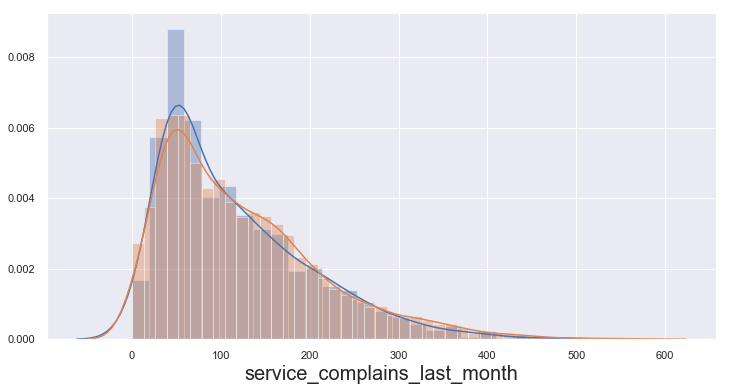

In [11]:
pass_ins = food_business[food_business['CriticalFound'] == 1]
fail_ins = food_business[food_business['CriticalFound'] == 0]
#plt.xlim(-10, 500)
sns.distplot(pass_ins['service_complains_last_month'], hist=True, label='pass')
sns.distplot(fail_ins['service_complains_last_month'], hist=True, label='fail')
plt.show()

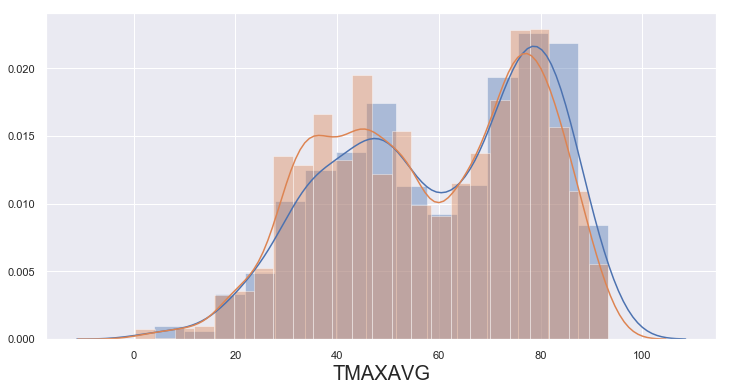

In [12]:
sns.distplot(pass_ins['TMAXAVG'], hist=True, label='pass')
sns.distplot(fail_ins['TMAXAVG'], hist=True, label='fail')
plt.show()

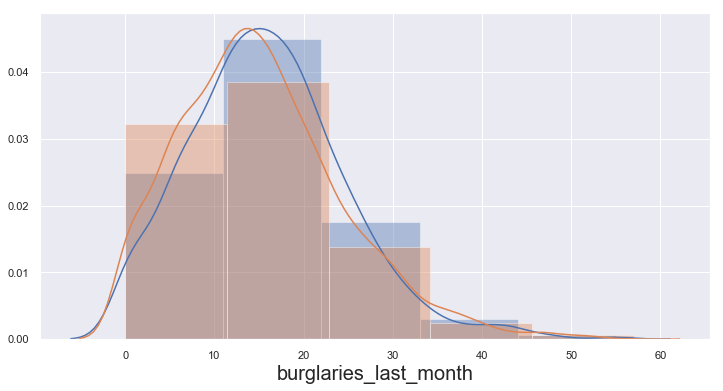

In [13]:
sns.distplot(pass_ins['burglaries_last_month'], bins=5, label='pass')
sns.distplot(fail_ins['burglaries_last_month'], bins=5, label='fail')
plt.show()

In [14]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws

    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)

    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha,
                                  alternative=alternative,
                                  usevar='unequal')
    degfree = means.dof_satt()

    index = [
        'DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI',
        'High95CI'
    ]
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]],
                     index=index)

In [15]:
US_LON = -87.6403
US_LAT = 41.8787
food_business['distance_from_us'] = get_distance(US_LAT, US_LON,
    food_business['latitude'].values, food_business['longitude'].values)

In [16]:
positive_class = food_business[food_business['CriticalFound'] == True]
negative_class = food_business[food_business['CriticalFound'] == False]
test = t_test(positive_class['past_critical_violations'],
              negative_class['past_critical_violations'], 0.05)
print("T-test results for Past Critical Violations")
print(test)
test = t_test(positive_class['past_serious_violations'],
              negative_class['past_serious_violations'], 0.05)
print("T-test results for Past Serous Violations")
print(test)
test = t_test(positive_class['past_minor_violations'],
              negative_class['past_minor_violations'], 0.05)
print("T-test results for Past Minor Violations")
print(test)
# run the t-test at a 5% sig level
test = t_test(positive_class['service_complains_last_month'],
              negative_class['service_complains_last_month'], 0.05)
print("T-test results for service complains")
print(test)
test = t_test(positive_class['TMAXAVG'], negative_class['TMAXAVG'], 0.05)
print("T-test results for Max Temperature")
print(test)
test = t_test(positive_class['burglaries_last_month'],
              negative_class['burglaries_last_month'], 0.05)
print("T-test results for burglaries")
print(test)

T-test results for Past Critical Violations
DegFreedom    1894.195754
Difference       0.090635
Statistic        4.187481
PValue           0.000030
Low95CI          0.048186
High95CI         0.133084
dtype: float64
T-test results for Past Serous Violations
DegFreedom    2034.921101
Difference       0.082138
Statistic        2.289333
PValue           0.022162
Low95CI          0.011775
High95CI         0.152501
dtype: float64
T-test results for Past Minor Violations
DegFreedom    2009.132202
Difference       0.206779
Statistic        3.156627
PValue           0.001620
Low95CI          0.078311
High95CI         0.335246
dtype: float64
T-test results for service complains
DegFreedom    2212.001750
Difference      -7.134581
Statistic       -2.811009
PValue           0.004982
Low95CI        -12.111860
High95CI        -2.157302
dtype: float64
T-test results for Max Temperature
DegFreedom    2087.437477
Difference       2.308886
Statistic        3.831240
PValue           0.000131
Low95CI      

In [17]:
food_business = food_business[~food_business['neighborhood'].isna()]
food_business = pd.concat([food_business, pd.get_dummies(food_business['neighborhood'], prefix='town')],axis=1)

In [18]:
import gmaps
APIKEY= os.getenv('GMAPAPIKEY')
gmaps.configure(api_key=APIKEY)
def make_heatmap(locations, weights=None):
    fig = gmaps.figure()
    heatmap_layer = gmaps.heatmap_layer(locations)
    #heatmap_layer.max_intensity = 100
    heatmap_layer.point_radius = 8
    fig.add_layer(heatmap_layer)
    return fig
    
latitudes = food_business['latitude'] 
longitudes = food_business['longitude']
locations = zip(latitudes, longitudes)
fig = make_heatmap(locations)
fig

Figure(layout=FigureLayout(height='420px'))

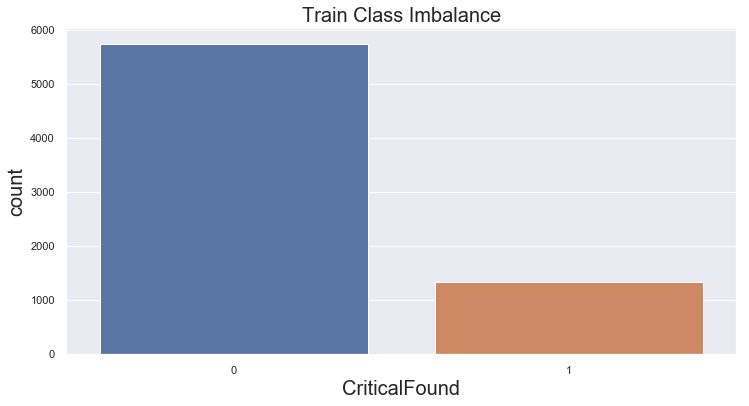

In [19]:
plt.title('Train Class Imbalance')
sns.countplot(x=food_business['CriticalFound'])

In [53]:

#food_business.set_index('inspection_date')
INSPECT_WINDOW = food_business['inspection_date'].max() - (pd.Timedelta(
    days=45))
print(INSPECT_WINDOW)
food_business_train_sample = food_business[(food_business['inspection_date'] <
                                            INSPECT_WINDOW)]
food_business_test_sample = food_business[(food_business['inspection_date'] >=
                                           INSPECT_WINDOW)]
print(food_business_train_sample.shape)
print(food_business_test_sample.shape)


2019-05-18 00:00:00
(6441, 134)
(637, 134)


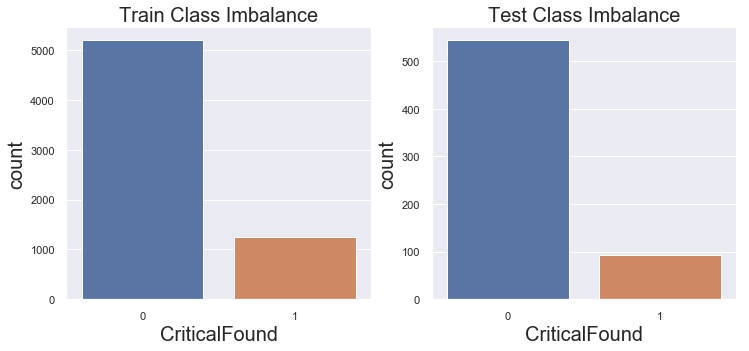

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Train Class Imbalance')
sns.countplot(x=food_business_train_sample['CriticalFound'], ax=ax1)
ax2.set_title('Test Class Imbalance')
sns.countplot(x=food_business_test_sample['CriticalFound'], ax=ax2)
plt.show()

In [55]:
features = [
    "past_minor_violations", "past_serious_violations",
    "past_critical_violations", "railway_station_count", "bus_station_count", "burglaries_last_month", 'distance_from_us',
    "service_complains_last_month", 'time_since_last_inspection', 'TMAXAVG'
]
for column in food_business.columns:
    if 'town' in column:
        features.append(column)

X = food_business_train_sample[features]
Y = food_business_train_sample['CriticalFound']

X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  Y,
                                                  test_size=0.3,
                                                  random_state=103)

In [56]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(4508, 86)
(4508,)
(1933, 86)
(1933,)


Since there is heavy class imbalance, We employ Synthetic Minority Over-sampling Technique (SMOTE) to generate new samples by randomly sampling with replacement the current available minority sample. Note that we only do this with the training sample. 

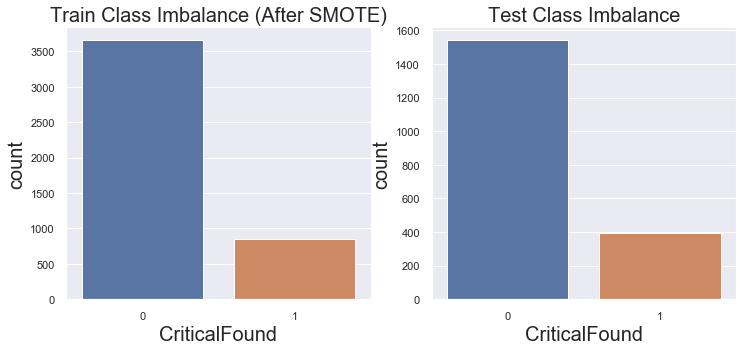

In [57]:
#from  imblearn.under_sampling import NearMiss
#nr = NearMiss()
#smote = SMOTE(ratio='minority')
#X_train, Y_train = nr.fit_resample(X_train, Y_train)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Train Class Imbalance (After SMOTE)')
sns.countplot(x=Y_train, ax=ax1)
ax2.set_title('Test Class Imbalance')
sns.countplot(x=Y_val, ax=ax2)
plt.show()

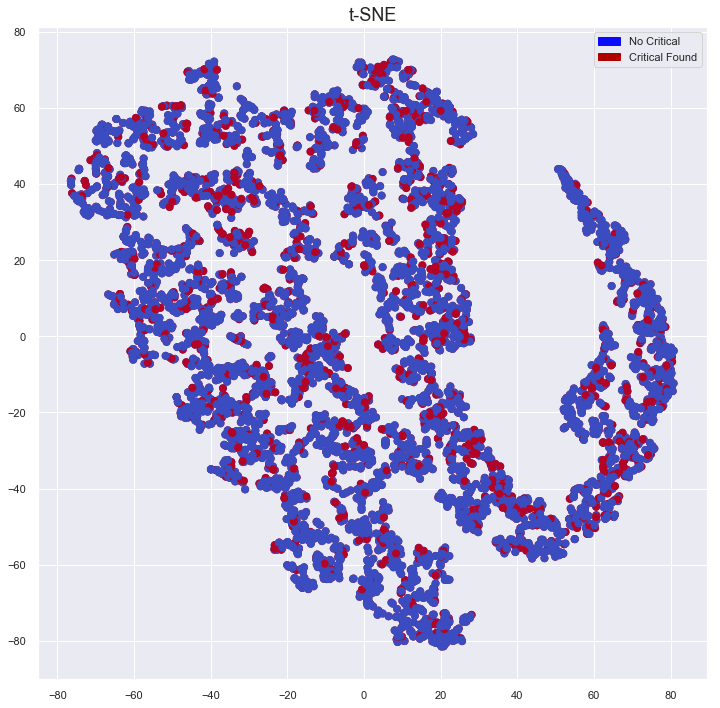

In [58]:
from sklearn.manifold import TSNE

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(12, 12))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Critical')
red_patch = mpatches.Patch(color='#AF0000', label='Critical Found')

ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_tsne[:, 1],
           c=(Y == 0),
           cmap='coolwarm',
           label='No Critical',
           linewidths=2)
ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_tsne[:, 1],
           c=(Y == 1),
           cmap='coolwarm',
           label='Critical Found',
           linewidths=2)
ax.set_title('t-SNE', fontsize=18)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])
plt.show()

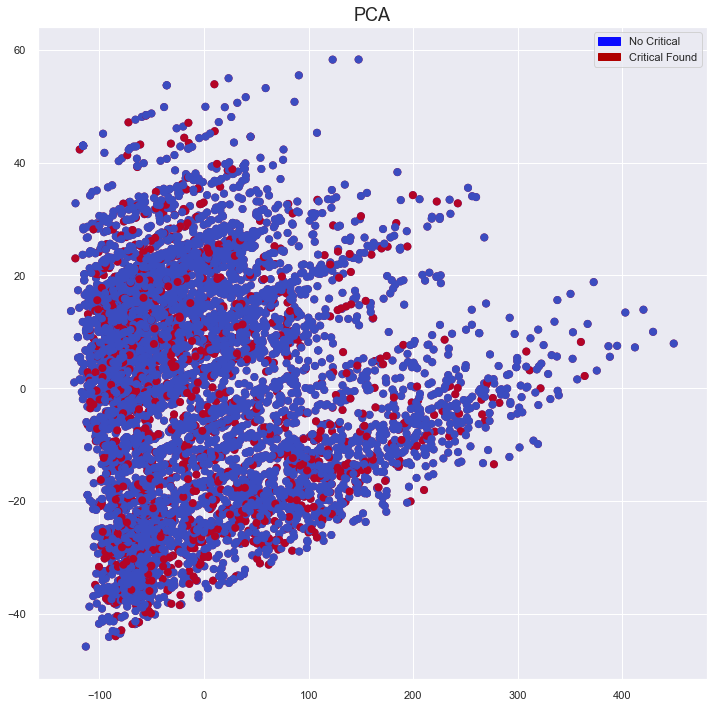

In [59]:
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=10, random_state=42).fit_transform(X.values)
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(12, 12))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Critical')
red_patch = mpatches.Patch(color='#AF0000', label='Critical Found')

ax.scatter(X_reduced_pca[:, 0],
           X_reduced_pca[:, 1],
           c=(Y == 0),
           cmap='coolwarm',
           label='No Critical',
           linewidths=2)
ax.scatter(X_reduced_pca[:, 0],
           X_reduced_pca[:, 1],
           c=(Y == 1),
           cmap='coolwarm',
           label='Critical Found',
           linewidths=2)
ax.set_title('PCA', fontsize=18)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])
plt.show()

In [60]:
def modelfit(alg,
             X_train,
             Y_train,
             performCV=True,
             printFeatureImportance=True,
             cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train)

    #Predict training set:
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:, 1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg,
                                   X_train,
                                   Y_train,
                                   cv=cv_folds,
                                   scoring='roc_auc')

    #Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" %
          metrics.accuracy_score(Y_train, train_predictions))
    print("AUC Score (Train): %f" %
          metrics.roc_auc_score(Y_train, train_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %
              (np.mean(cv_score), np.std(cv_score), np.min(cv_score),
               np.max(cv_score)))

    #Print Feature Importance:
    if printFeatureImportance:
        importances = alg.feature_importances_
        indices = np.argsort(importances)[::-1]
        names = [features[i] for i in indices]
        feat_imp = pd.Series(alg.feature_importances_,
                             names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


def summarize_model_performance(trained_model, x_data, true_label):
    y_pred = trained_model.predict(x_data)
    y_pred_proba = trained_model.predict_proba(x_data)[:, 1]

    print("Accuracy = %s " % metrics.accuracy_score(true_label, y_pred))
    print("F1 Score = %s " % metrics.f1_score(true_label, y_pred))
    print("ROC-AUC Score = %s " %
          metrics.roc_auc_score(true_label, y_pred_proba))
    print("Recall-Score = %s " % metrics.recall_score(true_label, y_pred))
    print("Confusion Matrix\n")
    print(metrics.confusion_matrix(true_label, y_pred))
    print("Classification report")
    print(metrics.classification_report(true_label, y_pred))
    print("Log-Loss = %.3f" % metrics.log_loss(true_label, y_pred_proba))

    plot_roc_auc_curve(true_label, y_pred_proba)
    plot_precision_recall_curve(true_label, y_pred_proba)


def plot_roc_auc_curve(true_label, pred_label_proba):
    plt.figure(figsize=(8, 8))
    fpr, tpr, thresholds = metrics.roc_curve(true_label, pred_label_proba)
    plt.plot(fpr, tpr, label=' (area = %0.2f)'\
             % metrics.roc_auc_score(true_label, pred_label_proba))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC-AUC curve ')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def plot_precision_recall_curve(true_label, pred_label_proba):
    plt.figure(figsize=(8, 8))
    precision, recall, thresholds = metrics.precision_recall_curve(
        true_label, pred_label_proba)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [0.1, 0.1], linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

## Logistic Regression Model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=101, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy = 0.7992757371960683 
F1 Score = 0.020202020202020204 
ROC-AUC Score = 0.6287677627832443 
Recall-Score = 0.01020408163265306 
Confusion Matrix

[[1541    0]
 [ 388    4]]
Classification report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1541
           1       1.00      0.01      0.02       392

    accuracy                           0.80      1933
   macro avg       0.90      0.51      0.45      1933
weighted avg       0.84      0.80      0.71      1933

Log-Loss = 0.488


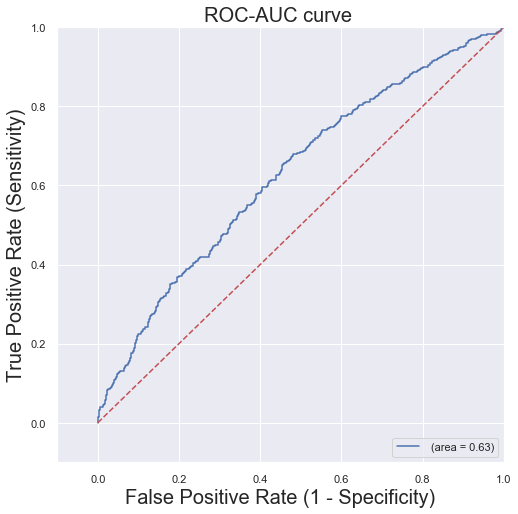

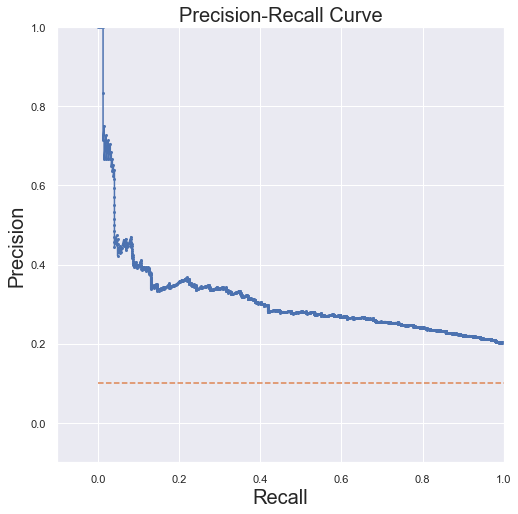

In [61]:
# train a logistic regression model on the training set
# instantiate model
logreg = LogisticRegression(random_state=101)
print(logreg)

logreg.fit(X_train, Y_train)
summarize_model_performance(logreg, X_val, Y_val)

In [62]:
param_grid = {
    'C': [0.5, 1, 1.5, 2.0, 2.5, 3.0, 4, 5],
    'class_weight': [None, "balanced"],
    'max_iter': [10, 20, 50, 100, 110, 120, 150, 200, 500, 700, 1000]
}

lgr_rand_search = RandomizedSearchCV(estimator=logreg,
                                     param_distributions=param_grid,
                                     n_iter=100,
                                     cv=5,
                                     n_jobs=-1,
                                     random_state=101)

lgr_rand_search.fit(X_train, Y_train)
#Best estimator and CV score
print('Best Accuracy score ', lgr_rand_search.best_score_)
print(lgr_rand_search.best_estimator_)

logreg = lgr_rand_search.best_estimator_
# fit model
modelfit(logreg, X_train, Y_train, True, False, 5)
print("Logistic regression coefficients \n")
print(logreg.coef_)

Best Accuracy score  0.8112244897959183
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=20,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=101, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Model Report
Accuracy : 0.8114
AUC Score (Train): 0.654909
CV Score : Mean - 0.604418 | Std - 0.01011743 | Min - 0.5900861 | Max - 0.6191197
Logistic regression coefficients 

[[ 0.05864023 -0.00724477  0.14656229 -0.00598743  0.35172388  0.0069984
  -0.04572208 -0.001646    0.13420977  0.00736947  0.51688667 -0.08095859
   0.23626313  0.00541751 -0.24184125  0.38820027 -0.07480071 -0.34989427
   0.10899104  0.3680561  -0.32897245 -0.52534752  0.03233107  0.37719228
  -0.48185846 -0.05178318 -0.03669779  0.1128644   0.6167385   0.3682951
   0.28642218  0.57322049 -0.14009263  0.2280564  -0.19535558 -0.31586948
  -0.30158    -0.0

Accuracy = 0.7982410760475944 
F1 Score = 0.01015228426395939 
ROC-AUC Score = 0.6269699638453695 
Recall-Score = 0.00510204081632653 
Confusion Matrix

[[1541    0]
 [ 390    2]]
Classification report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1541
           1       1.00      0.01      0.01       392

    accuracy                           0.80      1933
   macro avg       0.90      0.50      0.45      1933
weighted avg       0.84      0.80      0.71      1933

Log-Loss = 0.488


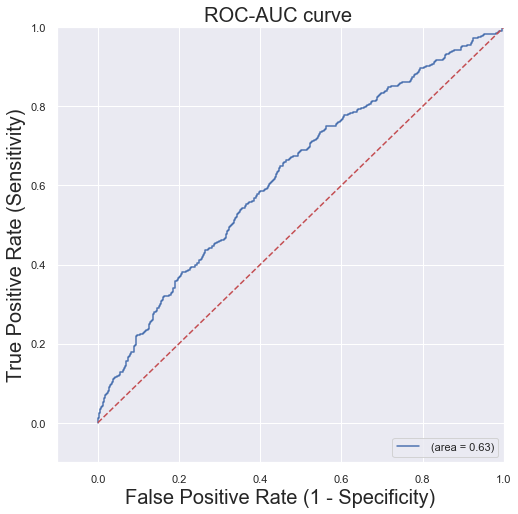

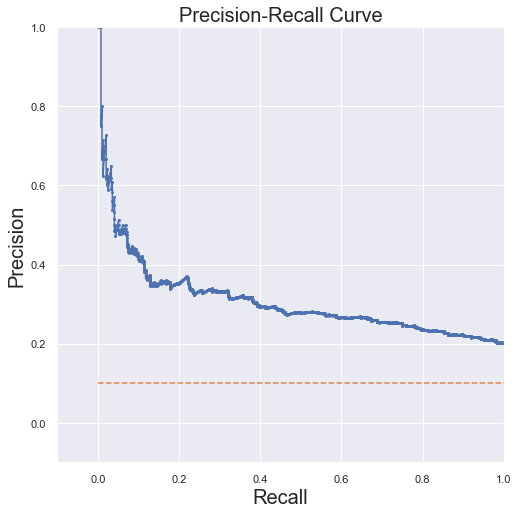

In [63]:
summarize_model_performance(logreg, X_val, Y_val)

Test Summary 
Accuracy = 0.8524332810047096 
F1 Score = 0.0 
ROC-AUC Score = 0.6687025616698292 
Recall-Score = 0.0 
Confusion Matrix

[[543   1]
 [ 93   0]]
Classification report
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       544
           1       0.00      0.00      0.00        93

    accuracy                           0.85       637
   macro avg       0.43      0.50      0.46       637
weighted avg       0.73      0.85      0.79       637

Log-Loss = 0.404


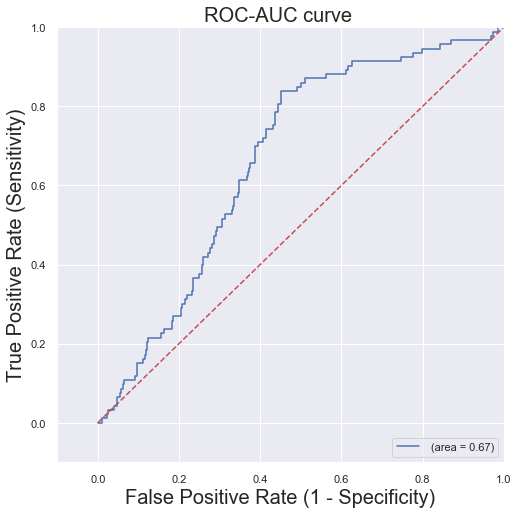

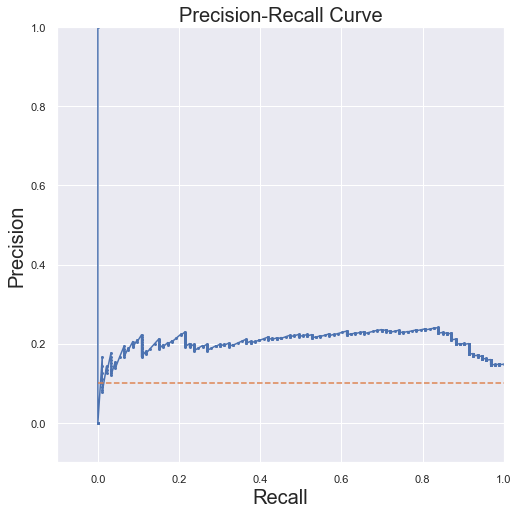

In [64]:
X_test = food_business_test_sample[features]
Y_test = food_business_test_sample['CriticalFound']
print('Test Summary ')
summarize_model_performance(logreg, X_test, Y_test)

## Random Forest Classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=101, verbose=0,
                       warm_start=False)
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=10, max_features=17, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=174,
                       n_jobs=-1, oob_score=False, random_state=101, verbose=0,
                       warm_start=False)

Model Report
Accuracy : 

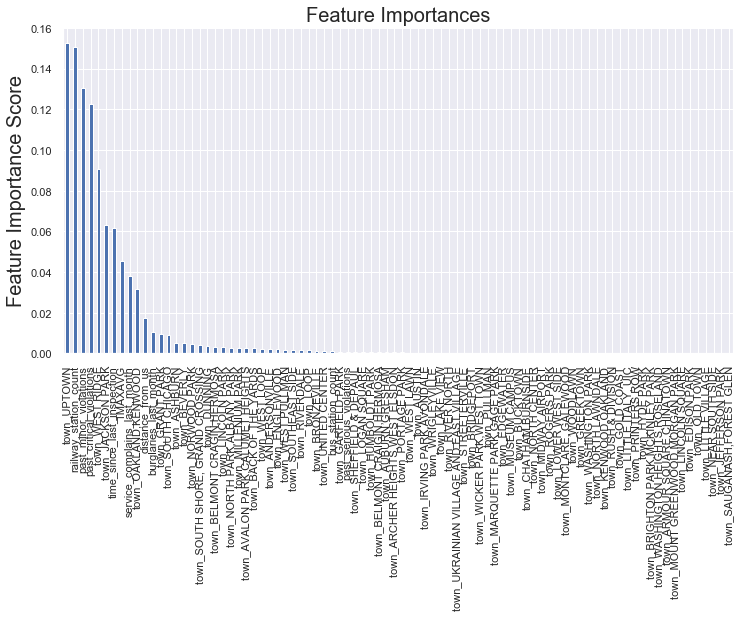

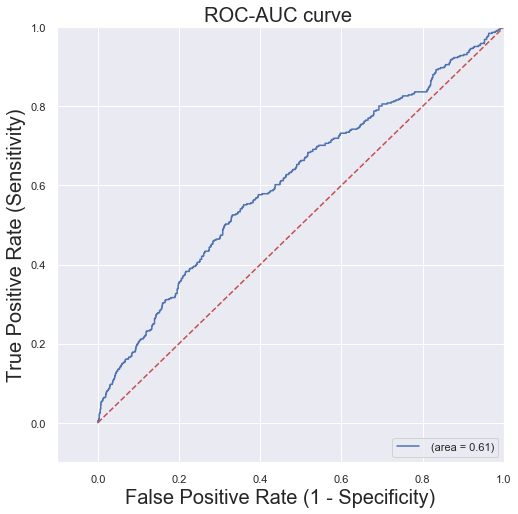

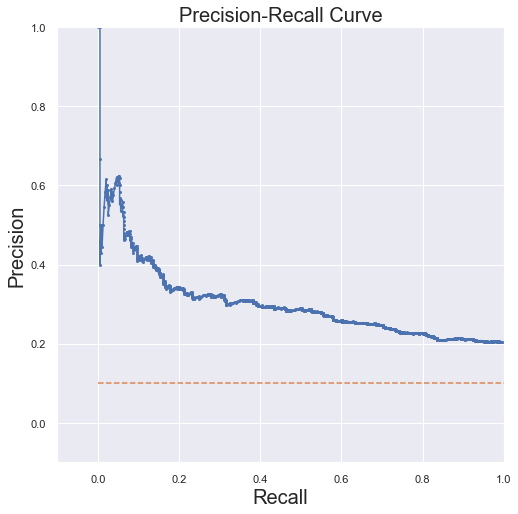

In [65]:
rf = RandomForestClassifier(random_state=101, n_jobs=-1)
print(rf)

# Train RF classifier
n_estimators = [int(x) for x in np.linspace(start=1, stop=500, num=50)]
param_grid_RF = {
    'n_estimators': n_estimators,
    'max_features': np.arange(1, len(features)),
    'min_samples_split': [2, 4, 6, 8],
    'max_depth': [1, 5, 10, 15, 20, 30, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'bootstrap': [True, False]
}
rf_rand_search = RandomizedSearchCV(estimator=rf,
                                    param_distributions=param_grid_RF,
                                    n_iter=10,
                                    cv=5,
                                    random_state=101)
rf_rand_search.fit(X_train, Y_train)
print(rf_rand_search.best_estimator_)
clf = rf_rand_search.best_estimator_
modelfit(clf, X_train, Y_train, True, True, 5)
summarize_model_performance(clf, X_val, Y_val)

## Gradient Boosting Classifier 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Model Report
Accuracy : 0.7679
AUC Score (Train): 0.848330
CV Score : Mean - 0.6786783 | Std - 0.04108312 | Min - 0.6279412 | Max - 0.7248962
Accuracy = 0.4671495085359545 
F1 Score = 0.3187830687830688 
ROC-AUC Score = 0.5337095578010568 
Recall-Score = 0.6147959183673469 
Confusion Matrix

[[662 879]
 [151 241]]
Classific

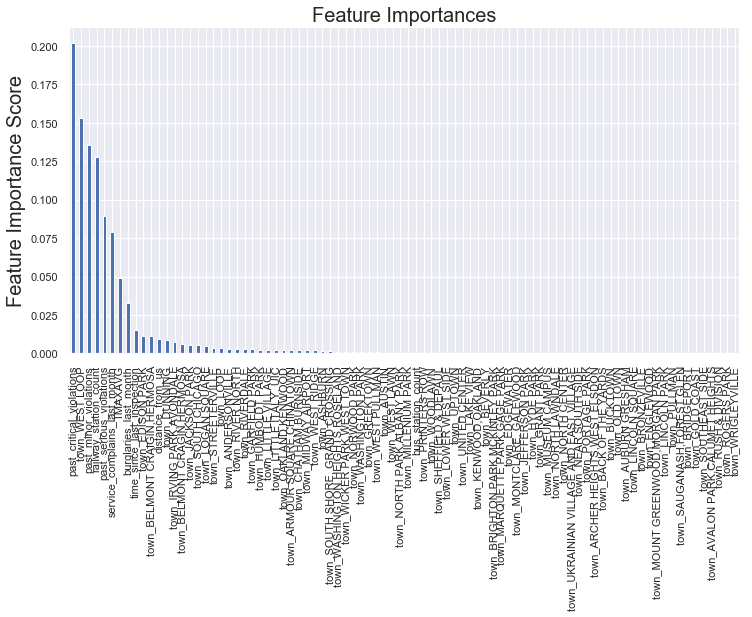

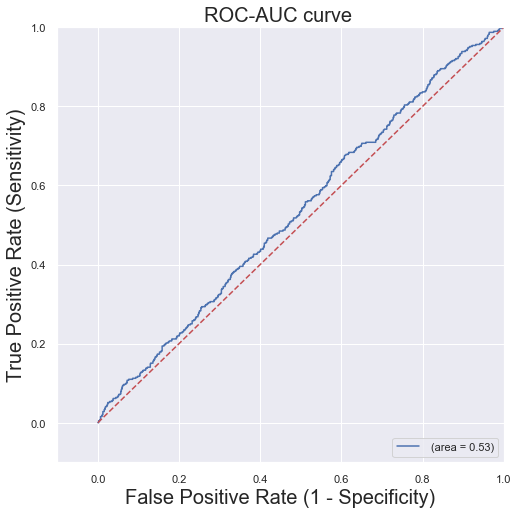

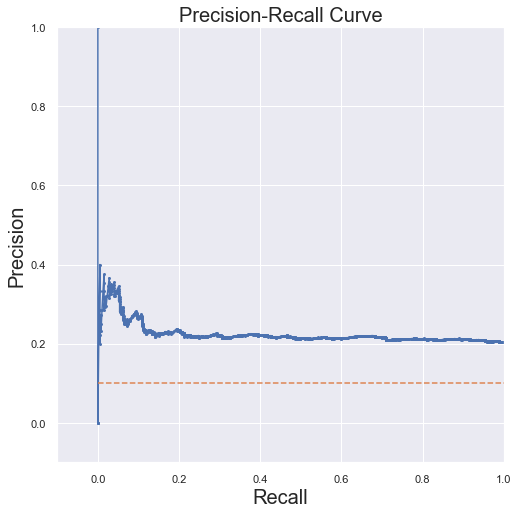

In [44]:
gbm0 = GradientBoostingClassifier(random_state=10)
print(gbm0)
modelfit(gbm0, X_train, Y_train)
summarize_model_performance(gbm0, X_val, Y_val)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85]
Best Accuracy score  0.6427732079905993
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=14, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy = 0.468701500258665

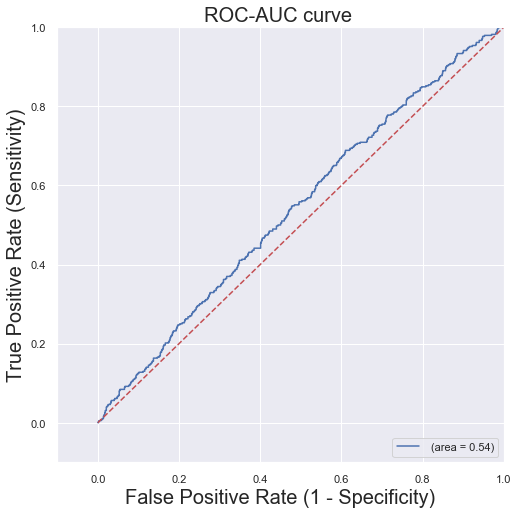

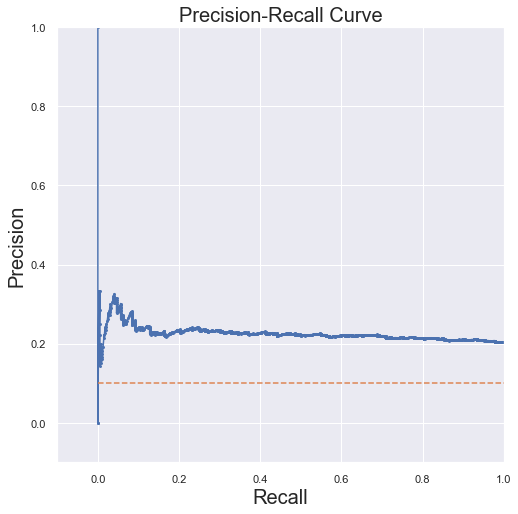

In [45]:
n_features = np.arange(1, len(features))
print(n_features)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'n_estimators': [100, 150, 200, 500],
    'max_features': n_features
}
#gbm_model_tuned = GradientBoostingClassifier(random_state=10)
gbm_grid_search = RandomizedSearchCV(estimator=gbm0,
                                     param_distributions=param_grid,
                                     cv=10,
                                     random_state=10,
                                     n_jobs=-1)

gbm_grid_search.fit(X_train, Y_train)

print('Best Accuracy score ', gbm_grid_search.best_score_)
print(gbm_grid_search.best_estimator_)

gbm_final = gbm_grid_search.best_estimator_
summarize_model_performance(gbm_final, X_val, Y_val)

## XGBoost Classifier

In [46]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", eval_metric = "error", random_state=101)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 18, 20, 25],
    'n_estimators': [100, 200, 300, 500, 1000],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}
xgb_grid_search = RandomizedSearchCV(estimator=xgb_model,
                                     param_distributions=param_grid,
                                     cv=5,
                                     random_state=101,
                                     n_jobs=-1)
X_train = pd.DataFrame(data=X_train, columns=features)
X_val = pd.DataFrame(data=X_val, columns=features)
xgb_grid_search.fit(X_train, Y_train)
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

xgb_model = xgb_grid_search.best_estimator_
print('Validation Summary ')
summarize_model_performance(xgb_model, X_val, Y_val)

KeyboardInterrupt: 